# Fastjet Issue?

In [4]:
import fastjet
import awkward as ak
import uproot
import warnings
import numpy as np
import hist
import vector
vector.register_awkward()

In [2]:
# Custom Recombiners
class E0_scheme:
    '''
    E0 Scheme Recombiner
    Find the C++ equivalent at https://github.com/HEP-FCC/FCCAnalyses/blob/master/addons/FastJet/src/ExternalRecombiner.cc
    '''
    def preprocess(p):
        pass
    def recombine(pa, pb):
        psum = pa+pb
        pmag = np.sqrt(psum.px()**2 + psum.py()**2 + psum.pz()**2)
        E0scale = psum.E() / pmag
        psum.reset(
                psum.px()*E0scale,
                psum.py()*E0scale,
                psum.pz()*E0scale,
                psum.E()
        )
        return psum

In [3]:
def remove_muons(reco):
    '''Remove muons in a silly way:
    Remove any reco particle in the mass range 0.10566 +/- 0.03
    '''
    err = 0.03
    ll = reco.mass <= abs(0.10566-err)
    hl = reco.mass >= abs(0.10566+err)
    ll = ak.drop_none(ll)
    hl = ak.drop_none(hl)
    return reco[ll | hl]

In [31]:

def process(events):

    Reco = ak.zip(
        {
            'E':events['ReconstructedParticles/ReconstructedParticles.energy'].arrays()['ReconstructedParticles.energy'],
            'px':events['ReconstructedParticles/ReconstructedParticles.momentum.x'].arrays()['ReconstructedParticles.momentum.x'],
            'py':events['ReconstructedParticles/ReconstructedParticles.momentum.y'].arrays()['ReconstructedParticles.momentum.y'],
            'pz':events['ReconstructedParticles/ReconstructedParticles.momentum.z'].arrays()['ReconstructedParticles.momentum.z'],
        },
        with_name='Momentum4D'
    )
                  
    
    pseudo_jets = remove_muons(Reco)

    #Ensure there are at least 2 reco particles before clustering
    pseudo_jets = pseudo_jets[ak.num(pseudo_jets, axis=1) > 1]
    
    jetdef = fastjet.JetDefinition0Param(fastjet.ee_kt_algorithm)
    
    jetdef.set_python_recombiner(E0_scheme)
    
    cluster = fastjet.ClusterSequence(pseudo_jets, jetdef)
    
    jets = cluster.exclusive_jets(2)
    
    jet_constituents = cluster.exclusive_jets_constituents(2)
    
    dijets = ak.sum(jets, axis=1)

    h = hist.Hist.new.Reg(100,0,200).Double().fill(dijets.mass)

    return {'dijet_mass': h}


## Run the processor

In [32]:
######################
# Define the fileset #
######################
# redirector = 'root://eospublic.cern.ch//'
redirector = ''
''' In case of problems, Download the root files from the following links:
https://prayag.web.cern.ch/share/FCC/eos/experiment/fcc/ee/generation/DelphesEvents/winter2023/IDEA/wzp6_ee_mumuH_Hbb_ecm240/events_159112833.root
'''

events_path = redirector+'eos/experiment/fcc/ee/generation/DelphesEvents/winter2023/IDEA/wzp6_ee_mumuH_Hbb_ecm240/events_159112833.root:events'

In [33]:
def _remove_not_interpretable(branch, emit_warning=True):
    if isinstance(
        branch.interpretation, uproot.interpretation.identify.uproot.AsGrouped
    ):
        for name, interpretation in branch.interpretation.subbranches.items():
            if isinstance(
                interpretation, uproot.interpretation.identify.UnknownInterpretation
            ):
                if emit_warning:
                    warnings.warn(
                        f"Skipping {branch.name} as it is not interpretable by Uproot"
                    )
                return False
    if isinstance(
        branch.interpretation, uproot.interpretation.identify.UnknownInterpretation
    ):
        if emit_warning:
            warnings.warn(
                f"Skipping {branch.name} as it is not interpretable by Uproot"
            )
        return False

    try:
        _ = branch.interpretation.awkward_form(None)
    except uproot.interpretation.objects.CannotBeAwkward:
        if emit_warning:
            warnings.warn(
                f"Skipping {branch.name} as it is it cannot be represented as an Awkward array"
            )
        return False
    else:
        return True

events = uproot.open(
    events_path,
    open_files=False,
    filter_name =  lambda x : "PARAMETERS" not in x,
    filter_branch = _remove_not_interpretable
)

In [35]:
out = process(events)

#--------------------------------------------------------------------------
#                         FastJet release 3.4.3
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fc6bec72f60>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

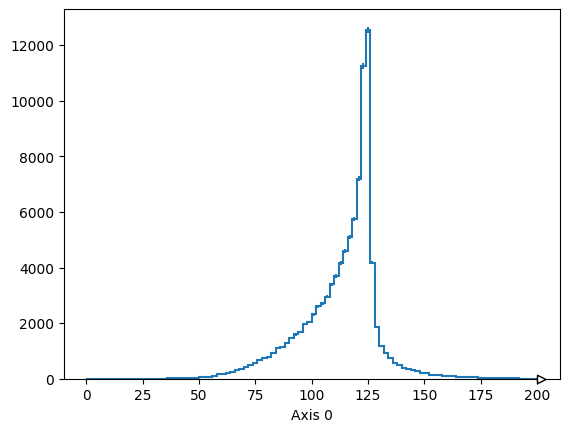

In [36]:
out['dijet_mass'].plot()

### This simplest example uses a lot of RAM

For a more realistic analyses, workers die because of hitting the RAM ceiling.
Wondering if this could be avoided

Total number of events in the current example : 100K
File size: 891 MB

RAM used: 7-8 GB

In the graph below refer to the green line in Memory:
The leftmost flat section : Idle
Upwards slope: The code executes
The rightmost flat section: Execution is completed but the Memory is not released

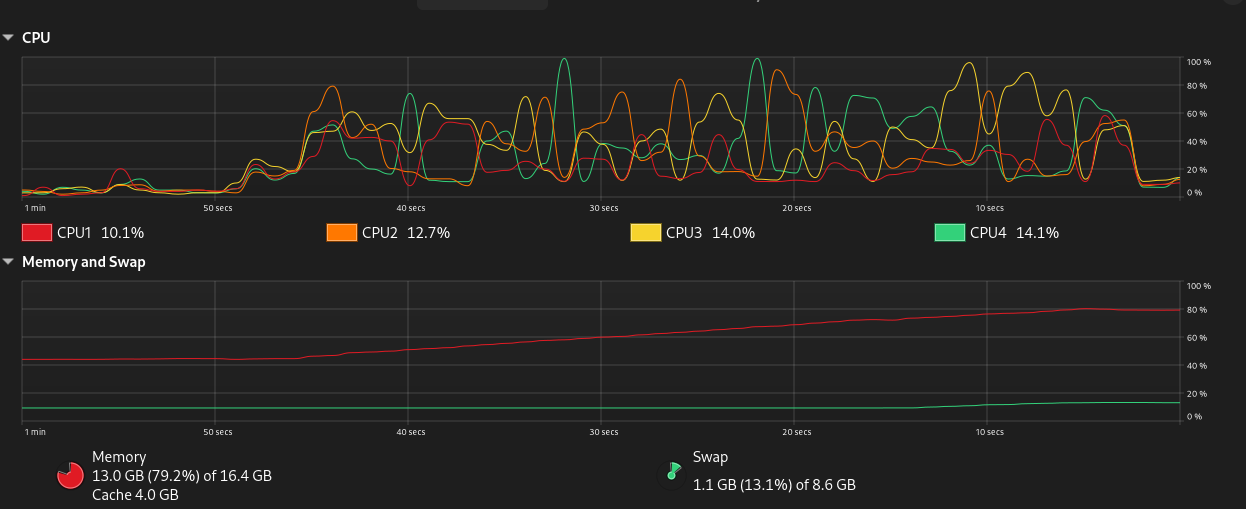

# Moreover, the used up memory is not released unless I restart my jupyter Kernel